### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns



from nltk.corpus import stopwords
from numpy import array
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from IPython.display import SVG

In [2]:
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', delimiter = '\t')
data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


### Data Exploration and Processing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


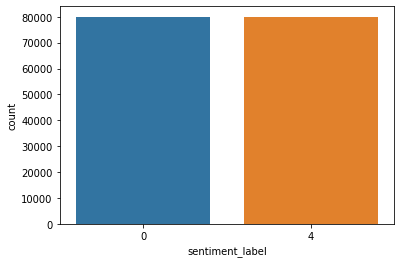

In [4]:
sns.countplot(x='sentiment_label', data = data)

In [5]:
data['tweet_text'][4]

"very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years "

In [6]:
def preprocess_text(sentence):
   # Removing links
    sentence = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',sentence)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

In [7]:
X = []
sentences = list(data['tweet_text'])
for sen in sentences:
    X.append(preprocess_text(sen))
    

In [8]:
y = data['sentiment_label']

y = np.array(list(map(lambda x: 1 if x==4 else 0, y)))


In [9]:
# Split dataset into training, validation and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=7)



print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

144000 144000
16000 16000


In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [11]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [13]:
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [14]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.6))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


callbacks = [EarlyStopping(monitor="val_loss", patience=10)]

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          22377800  
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          128128    
                                                                 
 dropout (Dropout)           (None, 196, 128)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

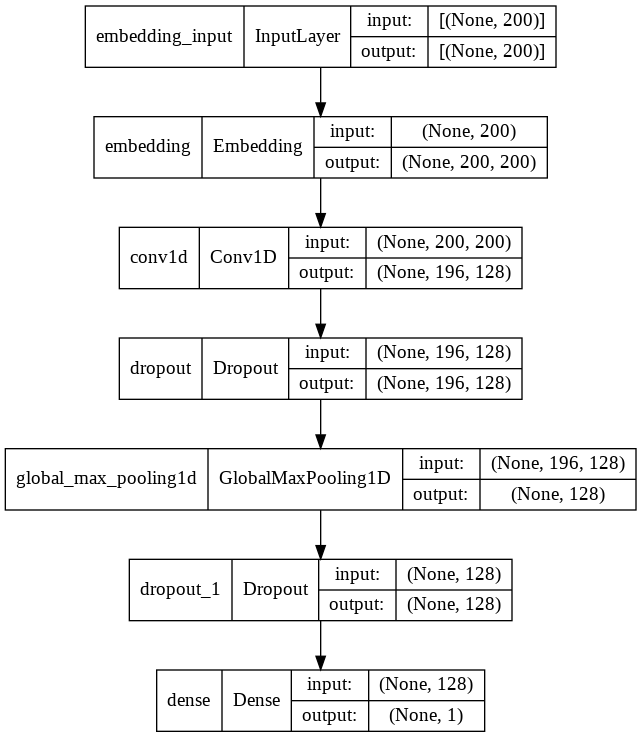

In [16]:
# Network Architecture
plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, callbacks=callbacks, validation_split=0.11)

Epoch 1/10
1002/1002 [==============================] - 30s 21ms/step - loss: 0.6106 - acc: 0.6712 - val_loss: 0.5623 - val_acc: 0.7229
Epoch 2/10
1002/1002 [==============================] - 21s 21ms/step - loss: 0.5684 - acc: 0.7075 - val_loss: 0.5481 - val_acc: 0.7330
Epoch 3/10
1002/1002 [==============================] - 21s 21ms/step - loss: 0.5590 - acc: 0.7146 - val_loss: 0.5425 - val_acc: 0.7442
Epoch 4/10
1002/1002 [==============================] - 21s 21ms/step - loss: 0.5524 - acc: 0.7201 - val_loss: 0.5389 - val_acc: 0.7456
Epoch 5/10
1002/1002 [==============================] - 20s 20ms/step - loss: 0.5483 - acc: 0.7237 - val_loss: 0.5347 - val_acc: 0.7462
Epoch 6/10
1002/1002 [==============================] - 20s 20ms/step - loss: 0.5442 - acc: 0.7258 - val_loss: 0.5311 - val_acc: 0.7448
Epoch 7/10
1002/1002 [==============================] - 20s 20ms/step - loss: 0.5417 - acc: 0.7270 - val_loss: 0.5316 - val_acc: 0.7482
Epoch 8/10
1002/1002 [==========================

#### Performance Evaluation

In [18]:
score = model.evaluate(x_test, y_test, verbose=1)

500/500 [==============================] - 3s 5ms/step - loss: 0.5186 - acc: 0.7524


In [19]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5186195969581604
Test Accuracy: 0.7524374723434448


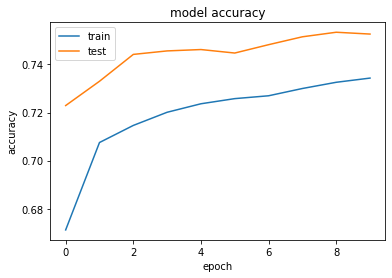

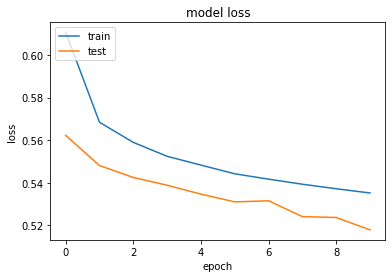

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

### Bidirectional LSTM

In [21]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [22]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          22377800  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              336896    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22,714,953
Trainable params: 337,153
Non-trainable params: 22,377,800
_________________________________________________________________
None


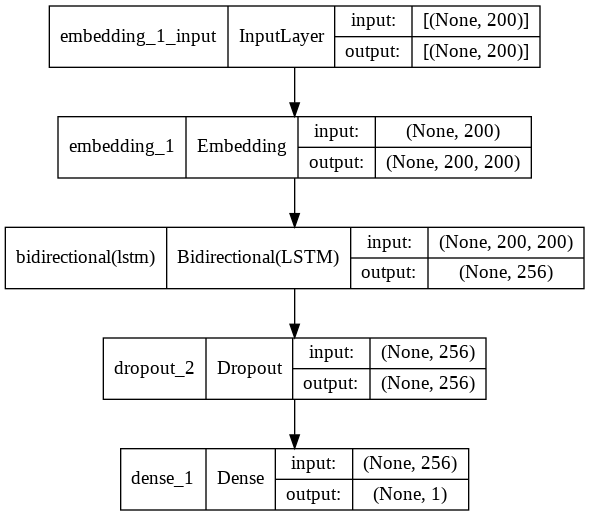

In [23]:
# Network Architecture
plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.11)

Epoch 1/10
1002/1002 [==============================] - 110s 105ms/step - loss: 0.5620 - acc: 0.7080 - val_loss: 0.5292 - val_acc: 0.7330
Epoch 2/10
1002/1002 [==============================] - 105s 105ms/step - loss: 0.5129 - acc: 0.7457 - val_loss: 0.4928 - val_acc: 0.7590
Epoch 3/10
1002/1002 [==============================] - 105s 105ms/step - loss: 0.4895 - acc: 0.7620 - val_loss: 0.4838 - val_acc: 0.7640
Epoch 4/10
1002/1002 [==============================] - 105s 105ms/step - loss: 0.4748 - acc: 0.7720 - val_loss: 0.4734 - val_acc: 0.7715
Epoch 5/10
1002/1002 [==============================] - 104s 104ms/step - loss: 0.4631 - acc: 0.7797 - val_loss: 0.4759 - val_acc: 0.7688
Epoch 6/10
1002/1002 [==============================] - 104s 104ms/step - loss: 0.4511 - acc: 0.7862 - val_loss: 0.4687 - val_acc: 0.7743
Epoch 7/10
1002/1002 [==============================] - 104s 104ms/step - loss: 0.4409 - acc: 0.7931 - val_loss: 0.4679 - val_acc: 0.7766
Epoch 8/10
1002/1002 [============

#### Performance Evaluation

In [25]:
score = model.evaluate(x_test, y_test, verbose=1)

500/500 [==============================] - 18s 35ms/step - loss: 0.5021 - acc: 0.7607


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

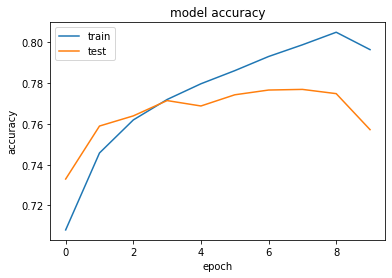

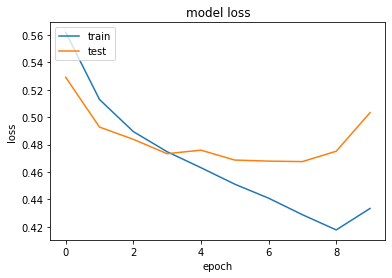

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [28]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      8133
           1       0.75      0.77      0.76      7867

    accuracy                           0.76     16000
   macro avg       0.76      0.76      0.76     16000
weighted avg       0.76      0.76      0.76     16000

